In [45]:
from cmdstanpy import model
import numpy as np
import scanpy as sc
import json
import pandas as pd
import os
from cmdstanpy import cmdstan_path, CmdStanModel
import scipy.stats as stats
import matplotlib.pyplot as plt

Note this combined model takes much longer to converge than the plain scHPF or GMM. This is likely because once one part gets a good fit the other half still hasnt converged, but then once the secon

In [2]:
from cmdstanpy import cmdstan_path, set_cmdstan_path
set_cmdstan_path('/Users/alexander/cmdstan')

In [3]:
#only run this is necessary, takes a while
adata=sc.read_h5ad("/Users/alexander/classes/Ml prob prog/project/N_ribas310_full.h5")
X = adata.layers['counts']

In [6]:
import pandas as pd
infer=pd.read_csv("N_infer_full_10.16.21",index_col=0)

In [7]:
infer_list = np.array(infer).tolist()

In [11]:
small_infer = []
for i in range(200):
    curr = []
    for j in range(200):
        curr.append(infer_list[i][j])
        #flat_x.append(infer_list[i][j])
    small_infer.append(curr)

In [29]:
#X = list(X)
new_X = []
for i in range(len(X[0:200])):
    
    curr = []
    for j in range(len(X[0][0:200])):
       # if np.isnan(X[i][j]):
          #  print("GOT A NAN")
        curr.append(int(X[i][j]))
    new_X.append(curr)

In [32]:
#This takes quite a while... only run it once run below to change the hyperparams
data = {}
data['C'] = len(new_X)
data['G'] = len(new_X[0])

#hyperparameters, just holder values
data['a_prime'] = 1
data['b_prime'] = 1
data['a'] = 1

data['c_prime'] = 1
data['d_prime'] = 1
data['c'] = 1

data['k'] = 10

data['X'] = new_X

data['prior_mu'] = [.9109,1.001,1.1167]

data['infer'] = small_infer

scHPF_GMM_data = os.path.join(cmdstan_path(), 'scHPF_GMM','scHPF_GMM.data.json')
print(scHPF_data)
with open(scHPF_data, "w") as outfile:
    json.dump(data, outfile)

/Users/alexander/cmdstan/scHPF_GMM/scHPF_GMM.data.json


In [47]:
scHPF_GMM_stan = os.path.join('scHPF_GMM.stan')
scHPF_GMM_model = CmdStanModel(stan_file=scHPF_GMM_stan)
scHPF_GMM_model.name
scHPF_GMM_model.stan_file
scHPF_GMM_model.exe_file
scHPF_GMM_model.code()

INFO:cmdstanpy:compiling stan program, exe file: /var/folders/tl/_362fbkn33b40bs9pcwpbcfc0000gn/T/tmpurx6dsw6/tmpsvetr41y
INFO:cmdstanpy:compiler options: stanc_options={}, cpp_options={}
INFO:cmdstanpy:compiled model file: /Users/alexander/classes/Ml prob prog/project/scHPF_GMM


"data {\nint<lower=0> C;\nint<lower=0> G;\n\nreal<lower=0> a_prime;\nreal<lower=0> b_prime;\nreal<lower=0> a;\n\nreal<lower=0> c_prime;\nreal<lower=0> d_prime;\nreal<lower=0> c;\n\nint<lower=0> k;\n\nint<lower=0> X[C,G];\n\n\nreal infer[C,G];\n\nreal prior_mu[3];\n\n\n\n\n\n\n\n}\n\nparameters {\nsimplex[3] pi; #mixing proportion\nvector<lower=0>[3] sigma;\nmatrix<lower=0> [C,k] theta;\nmatrix<lower=0> [G,k] beta;\nvector<lower=0>[G] eta;\nvector<lower=0>[C] xi;\n\n\n\n}\nmodel {\n\n  vector[3] contributions;\n\n#  mu ~ normal(prior_mu,.5);\n  sigma ~ normal(0,.5);\n\n  pi ~ dirichlet([1.,1.,1.]');\n\n  for (cc in 1:C){\n    for (g in 1:G){\n      for (kk in 1:3){\n        contributions[kk] = log(pi[kk])+normal_lpdf(infer[cc][g] | prior_mu[kk], sigma[kk]) ;\n      }\n      target += log_sum_exp(contributions) ;\n    }\n  }\n\n  int mixture[C,G] = rep_array(1, C, G);\n  real ps[3];\n  for (cc in 1:C){\n    for (g in 1:G){\n      for (kk in 1:3){\n        ps[kk] = log(pi[kk]) + (normal_l

In [ ]:
scHPF_GMM_fit = scHPF_GMM_model.variational(data=scHPF_GMM_data, output_dir='.',show_console=True,require_converged=False,tol_rel_obj=.001,iter=10000)




INFO:cmdstanpy:Chain [1] start processing


Chain [1] method = variational
Chain [1] variational
Chain [1] algorithm = meanfield (Default)
Chain [1] meanfield
Chain [1] iter = 10000 (Default)
Chain [1] grad_samples = 1 (Default)
Chain [1] elbo_samples = 100 (Default)
Chain [1] eta = 1 (Default)
Chain [1] adapt
Chain [1] engaged = 1 (Default)
Chain [1] iter = 50 (Default)
Chain [1] tol_rel_obj = 0.001
Chain [1] eval_elbo = 100 (Default)
Chain [1] output_samples = 1000 (Default)
Chain [1] id = 1 (Default)
Chain [1] data
Chain [1] file = /Users/alexander/cmdstan/scHPF_GMM/scHPF_GMM.data.json
Chain [1] init = 2 (Default)
Chain [1] random
Chain [1] seed = 99517
Chain [1] output
Chain [1] file = /Users/alexander/classes/Ml prob prog/project/scHPF_GMM-20211126173213.csv
Chain [1] diagnostic_file =  (Default)
Chain [1] refresh = 100 (Default)
Chain [1] sig_figs = -1 (Default)
Chain [1] profile_file = profile.csv (Default)
Chain [1] num_threads = 1 (Default)
Chain [1] 
Chain [1] -----------------------------------------------------------

In [41]:
scHPF_GMM_fit.variational_params_dict

OrderedDict([('lp__', 0.0),
             ('log_p__', 0.0),
             ('log_g__', 0.0),
             ('theta[1,1]', 0.167982),
             ('theta[2,1]', 0.0727059),
             ('theta[3,1]', 0.0517208),
             ('theta[4,1]', 0.134361),
             ('theta[5,1]', 0.761666),
             ('theta[6,1]', 0.0995581),
             ('theta[7,1]', 0.0510338),
             ('theta[8,1]', 0.258435),
             ('theta[9,1]', 0.452869),
             ('theta[10,1]', 0.120102),
             ('theta[11,1]', 0.163598),
             ('theta[12,1]', 0.113332),
             ('theta[13,1]', 0.145197),
             ('theta[14,1]', 0.196914),
             ('theta[15,1]', 0.0416538),
             ('theta[16,1]', 0.139515),
             ('theta[17,1]', 0.103286),
             ('theta[18,1]', 0.202628),
             ('theta[19,1]', 0.372233),
             ('theta[20,1]', 0.0727575),
             ('theta[21,1]', 0.0646158),
             ('theta[22,1]', 0.0774698),
             ('theta[23,1]', 0.

mean is 0.9109


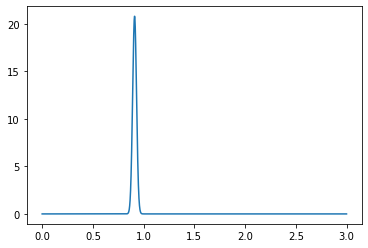

mean is 1.001


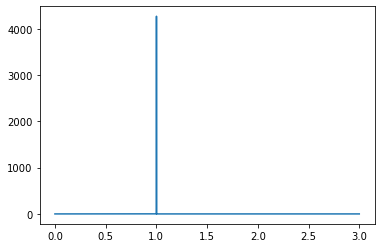

mean is 1.1167


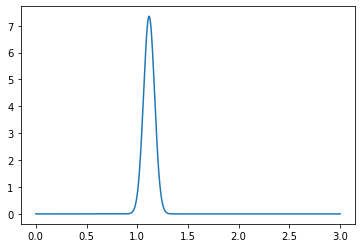

In [46]:
for i in range(1,4):
    mu = [.9109,1.001,1.1167][i-1]#'mu[' + str(i) + ']'
    sigma = 'sigma[' + str(i) + ']'
  #  print("mean is ",GMM_fit.variational_params_dict[mu])
    print("mean is",mu)
    x = np.linspace(0,3,100000)
    y = stats.norm.pdf(x, loc=mu, scale=scHPF_GMM_fit.variational_params_dict[sigma])
    plt.plot(x,y)
    plt.show()